# Predicting Crime Rates within Boston Based on Various Spatial and Temporal Factors

By William Wang, 1004278818

# PROJECT ONE


This analysis was conducted to determine what factors may affect the number of crimes in Boston, primarily looking at factors dealing with when it is and where it is in Boston. The specific factors of interest in this analysis are the number of crimes that have occurred, which will be our dependent variable, and independent variables such as the hour, month, or year it is, the area of Boston, as well as weather patterns. The analysis found that there are certain times of day, week or month where crimes are more prevalent, as well as areas where crimes occur most often.

The purpose of this study will be to analyze crime rates within different part of Boston based on different factors. To do so we will be looking at a dataset pulled from Kaggle, available from https://www.kaggle.com/ankkur13/boston-crime-data, this set of data is extracted from the Boston Police Department (BPD), and represents records within the BPDs crime incident report system for the crimes reported between 2015 and 2018.

With this analysis, we hope to find when and where these crimes occurred and predict the likelihood of crimes occurring given certain factors. For this analysis, we will be looking at specific predictive indicators/variables such as date of crimes (Day of the week, month/year, hour of day, etc.), and location of crimes (The city district, the street, etc.). The outcome variable that we are trying to analyze is a count of crimes, i.e. the number of crimes that have occurred.

The following code is the required packages we will be using.

In [68]:
# Install below without hashtag, if not already done so
#! pip install qeds
#! pip install qeds geopandas xgboost gensim folium pyLDAvis descartes

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors
import seaborn as sns

from shapely.geometry import Point

from pylab import *

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

First, we need to extract our data from the provided csv file.

In [2]:
BostonCrimeCSV = pd.read_csv('crime.csv', encoding = 'latin-1', low_memory=False)

BostonCrimeDF = pd.DataFrame(BostonCrimeCSV)

Now we will extract the specific columns we want to look at, removing any that we don't need to use or columns that provide the same or similar information to other columns.

In [3]:
BostonCrimeDFCleaned = BostonCrimeDF[["OFFENSE_CODE_GROUP", "DISTRICT", "REPORTING_AREA", "YEAR", "MONTH", "DAY_OF_WEEK", "HOUR", "STREET", "Long", "Lat"]]

BostonCrimeDFCleaned[["OFFENSE_CODE_GROUP", "DISTRICT", "REPORTING_AREA", "YEAR"]]

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,YEAR
0,Disorderly Conduct,E18,495,2018
1,Property Lost,D14,795,2018
2,Other,B2,329,2018
3,Aggravated Assault,A1,92,2018
4,Aircraft,A7,36,2018
...,...,...,...,...
327815,Warrant Arrests,D4,285,2016
327816,Homicide,E18,520,2015
327817,Warrant Arrests,E18,520,2015
327818,Warrant Arrests,E13,569,2016


In [4]:
BostonCrimeDFCleaned[["MONTH", "DAY_OF_WEEK", "HOUR", "STREET", "Long", "Lat"]]

,MONTH,DAY_OF_WEEK,HOUR,STREET,Long,Lat
0,10,Wednesday,20,ARLINGTON ST,-71.121186,42.262608
1,8,Thursday,20,ALLSTON ST,-71.135311,42.352111
2,10,Wednesday,19,DEVON ST,-71.076930,42.308126
3,10,Wednesday,20,CAMBRIDGE ST,-71.059648,42.359454
4,10,Wednesday,20,PRESCOTT ST,-71.024663,42.375258
...,...,...,...,...,...,...
327815,6,Sunday,17,COVENTRY ST,-71.085748,42.336951
327816,7,Thursday,13,RIVER ST,-71.123172,42.255926
327817,7,Thursday,13,RIVER ST,-71.123172,42.255926
327818,5,Tuesday,19,NEW WASHINGTON ST,-71.111565,42.302333


Now we can group our data based on specific variables, first we will try to group by the district the crime was committed in.

In [5]:
BostonCrimeDFCleaned.groupby("DISTRICT").describe()

YEAR                                                         \
            count         mean       std     min     25%     50%     75%   
DISTRICT                                                                   
A1        36735.0  2016.606234  1.012138  2015.0  2016.0  2017.0  2017.0   
A15        6663.0  2016.615789  0.994764  2015.0  2016.0  2017.0  2017.0   
A7        13634.0  2016.558237  1.017714  2015.0  2016.0  2017.0  2017.0   
B2        51288.0  2016.579336  1.012866  2015.0  2016.0  2017.0  2017.0   
B3        36400.0  2016.615385  1.003050  2015.0  2016.0  2017.0  2017.0   
C11       43817.0  2016.570646  1.006547  2015.0  2016.0  2017.0  2017.0   
C6        24190.0  2016.622282  1.023753  2015.0  2016.0  2017.0  2017.0   
D14       20632.0  2016.601638  1.001256  2015.0  2016.0  2017.0  2017.0   
D4        43338.0  2016.590060  1.014206  2015.0  2016.0  2017.0  2017.0   
E13       17981.0  2016.607530  1.003202  2015.0  2016.0  2017.0  2017.0   
E18       17825.0  2016.637588  1.007401  2015.0  2016.0  2017.0  2017.0   
E5        13543.0  2016.610352  1.003937  2015.0  2016.0  2017.0  2017.0   

                    MONTH            ...       Long                 Lat  \
             max    count      mean  ...        75%        max    count   
DISTRICT                             ...                                  
A1        2018.0  36735.0  6.738397  ... -71.057582  -1.000000  32947.0   
A15       2018.0   6663.0  6.619841  ... -71.057414  -1.000000   6321.0   
A7        2018.0  13634.0  6.649626  ... -71.027300  -1.000000  13094.0   
B2        2018.0  51288.0  6.656684  ... -71.077283  -1.000000  47488.0   
B3        2018.0  36400.0  6.649560  ... -71.078400  -1.000000  34614.0   
C11       2018.0  43817.0  6.649314  ... -71.058638  -1.000000  42134.0   
C6        2018.0  24190.0  6.647210  ... -71.045417  -1.000000  22584.0   
D14       2018.0  20632.0  6.730128  ... -71.132884  -1.000000  19611.0   
D4        2018.0  43338.0  6.718953  ... -71.074364  -1.000000  39706.0   
E13       2018.0  17981.0  6.643735  ... -71.100760  -1.000000  17013.0   
E18       2018.0  17825.0  6.596690  ... -71.113742 -71.059009  17094.0   
E5        2018.0  13543.0  6.614709  ... -71.128362  -1.000000  13102.0   

                                                                           \
               mean       std        min        25%        50%        75%   
DISTRICT                                                                    
A1        42.331809  1.040916  -1.000000  42.352418  42.356541  42.361209   
A15       42.177052  2.931529  -1.000000  42.375449  42.377698  42.379612   
A7        42.360905  0.847546  -1.000000  42.371468  42.377736  42.381982   
B2        42.315238  0.526026  -1.000000  42.314344  42.321488  42.329464   
B3        42.283186  0.403153  -1.000000  42.279675  42.285613  42.294354   
C11       42.293225  0.558221  -1.000000  42.291681  42.300605  42.307821   
C6        42.210794  2.303619  -1.000000  42.328564  42.332354  42.337475   
D14       42.343654  0.536184  -1.000000  42.346730  42.350914  42.354419   
D4        42.341282  0.307679  -1.000000  42.339187  42.344167  42.348434   
E13       42.309925  0.469725  -1.000000  42.309719  42.315384  42.321774   
E18       42.262645  0.015356  42.232413  42.253330  42.262017  42.270181   
E5        42.199852  1.888978  -1.000000  42.275759  42.283709  42.288567   

                     
                max  
DISTRICT             
A1        42.376181  
A15       42.394213  
A7        42.395042  
B2        42.392146  
B3        42.372579  
C11       42.377463  
C6        42.385841  
D14       42.372466  
D4        42.377552  
E13       42.357826  
E18       42.357889  
E5        42.356024  

[12 rows x 40 columns]

In [6]:
BostonCrimeDFCleaned.groupby("DISTRICT").count().describe()

,OFFENSE_CODE_GROUP,REPORTING_AREA,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET,Long,Lat
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,27170.500000,27170.500000,27170.500000,27170.500000,27170.500000,27170.500000,26341.333333,25475.666667,25475.666667
std,14490.545328,14490.545328,14490.545328,14490.545328,14490.545328,14490.545328,13944.931972,13354.654955,13354.654955
min,6663.000000,6663.000000,6663.000000,6663.000000,6663.000000,6663.000000,6486.000000,6321.000000,6321.000000
25%,16777.250000,16777.250000,16777.250000,16777.250000,16777.250000,16777.250000,16425.250000,16035.250000,16035.250000
50%,22411.000000,22411.000000,22411.000000,22411.000000,22411.000000,22411.000000,21689.000000,21097.500000,21097.500000
75%,38385.750000,38385.750000,38385.750000,38385.750000,38385.750000,38385.750000,37140.250000,35887.000000,35887.000000
max,51288.000000,51288.000000,51288.000000,51288.000000,51288.000000,51288.000000,49445.000000,47488.000000,47488.000000


We can clearly see that certain areas of the city see varying levels of crime. For example, we can look at district B2 and see that it has the greatest number of crimes committed of any district, accounting for 15% of the total number of crimes between 2015-2018, thus we could see this as an area we want to closely monitor for the future. On the other hand, we can see that in district A15, we have the lowest crime rate, at 2% of total crimes. Thus, we can see that it is likely that the predictive variable district can help explain our outcome variable of crime rate/count. Furthermore, we found that for any given district, we saw an average of 27170.5 crimes occur, which can deviate by about 14490.5 giving us a range of about 12680 to 41660 crimes which we would deem not out of the ordinary. Thus by the fact that district A15 and B2 lie significantly outside of that range, with some other districts like C11 and D4 having crime counts closer to the range, we can deem all these districts as areas that have significantly different crime counts from the other districts.

This code and methodology can be applied to our other predictive variables, like year, month, hour, day of week, street and reporting area.

In [7]:
BostonCrimeDFCleaned.groupby("YEAR").describe()

MONTH                                                     HOUR  \
         count      mean       std  min  25%  50%   75%   max     count   
YEAR                                                                      
2015   53392.0  9.193831  1.880766  6.0  8.0  9.0  11.0  12.0   53392.0   
2016   99134.0  6.564307  3.389514  1.0  4.0  7.0   9.0  12.0   99134.0   
2017  100938.0  6.552111  3.361297  1.0  4.0  7.0   9.0  12.0  100938.0   
2018   74356.0  5.168446  2.574000  1.0  3.0  5.0   7.0  10.0   74356.0   

                 ...       Long           Lat                            \
           mean  ...        75%  max    count       mean       std  min   
YEAR             ...                                                      
2015  13.025360  ... -71.062204 -1.0  51263.0  42.285962  1.269104 -1.0   
2016  13.160651  ... -71.062483 -1.0  92312.0  42.208091  2.220026 -1.0   
2017  13.141602  ... -71.062495 -1.0  94097.0  42.215423  2.148728 -1.0   
2018  13.081688  ... -71.062563 -1.0  69516.0  42.162413  2.624337 -1.0   

                                                  
            25%        50%        75%        max  
YEAR                                              
2015  42.298620  42.326968  42.349020  42.395042  
2016  42.297332  42.324694  42.348527  42.395042  
2017  42.297145  42.325721  42.348624  42.395042  
2018  42.296904  42.325452  42.348277  42.395042  

[4 rows x 32 columns]

In [8]:
BostonCrimeDFCleaned.groupby("YEAR").count().describe()

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,MONTH,DAY_OF_WEEK,HOUR,STREET,Long,Lat
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,81955.000000,81511.500000,81955.000000,81955.000000,81955.000000,81955.000000,79210.750000,76797.000000,76797.000000
std,22576.256702,22403.350679,22576.256702,22576.256702,22576.256702,22576.256702,21092.190235,20371.576129,20371.576129
min,53392.000000,53263.000000,53392.000000,53392.000000,53392.000000,53392.000000,52110.000000,51263.000000,51263.000000
25%,69115.000000,68662.750000,69115.000000,69115.000000,69115.000000,69115.000000,67854.000000,64952.750000,64952.750000
50%,86745.000000,86209.000000,86745.000000,86745.000000,86745.000000,86745.000000,83263.000000,80914.000000,80914.000000
75%,99585.000000,99057.750000,99585.000000,99585.000000,99585.000000,99585.000000,94619.750000,92758.250000,92758.250000
max,100938.000000,100365.000000,100938.000000,100938.000000,100938.000000,100938.000000,98207.000000,94097.000000,94097.000000


Here we can see that there seems to have been decreased number of crimes during the year of 2015, which we may need further investigation to discover why. Furthermore, we can also see that on average, for any given year we would expect to see 81955 crimes to be committed, which can deviate by about 22576 crimes giving us a range of 59368 to 104571. Since, 2015s count falls outside of that range, we can conclude that there was statistically significant lower counts of crime for 2015.

In [9]:
BostonCrimeDFCleaned.groupby("MONTH").describe()

YEAR                                                                 \
         count         mean       std     min     25%     50%     75%     max   
MONTH                                                                           
1      23625.0  2016.998222  0.813447  2016.0  2016.0  2017.0  2018.0  2018.0   
2      21661.0  2016.983057  0.811016  2016.0  2016.0  2017.0  2018.0  2018.0   
3      24156.0  2016.982572  0.813101  2016.0  2016.0  2017.0  2018.0  2018.0   
4      24108.0  2016.993114  0.815569  2016.0  2016.0  2017.0  2018.0  2018.0   
5      26242.0  2017.013604  0.817013  2016.0  2016.0  2017.0  2018.0  2018.0   
6      30622.0  2016.736889  1.023628  2015.0  2016.0  2017.0  2018.0  2018.0   
7      34640.0  2016.519197  1.108107  2015.0  2016.0  2017.0  2017.0  2018.0   
8      35137.0  2016.516720  1.103047  2015.0  2016.0  2017.0  2017.0  2018.0   
9      34023.0  2016.493754  1.105754  2015.0  2016.0  2017.0  2017.0  2018.0   
10     26437.0  2016.072777  0.864954  2015.0  2015.0  2016.0  2017.0  2018.0   
11     23685.0  2016.005278  0.815747  2015.0  2015.0  2016.0  2017.0  2017.0   
12     23484.0  2015.980881  0.813075  2015.0  2015.0  2016.0  2017.0  2017.0   

          HOUR             ...       Long           Lat                       \
         count       mean  ...        75%  max    count       mean       std   
MONTH                      ...                                                 
1      23625.0  12.942476  ... -71.062204 -1.0  22345.0  42.230758  1.985066   
2      21661.0  13.057292  ... -71.062514 -1.0  20203.0  42.268269  1.523378   
3      24156.0  13.111070  ... -71.062195 -1.0  22471.0  42.223637  2.061815   
4      24108.0  13.140576  ... -71.062170 -1.0  22608.0  42.241623  1.865828   
5      26242.0  13.252305  ... -71.062679 -1.0  24444.0  42.238662  1.898119   
6      30622.0  13.165731  ... -71.062666 -1.0  28777.0  42.209205  2.209042   
7      34640.0  13.169717  ... -71.062343 -1.0  32518.0  42.133172  2.856784   
8      35137.0  13.103111  ... -71.062138 -1.0  32810.0  42.189113  2.400194   
9      34023.0  13.153102  ... -71.062571 -1.0  31807.0  42.194849  2.351923   
10     26437.0  13.001778  ... -71.062135 -1.0  24739.0  42.239042  1.906759   
11     23685.0  13.088073  ... -71.062759 -1.0  22276.0  42.209556  2.207986   
12     23484.0  13.134262  ... -71.062145 -1.0  22190.0  42.234192  1.949232   

                                                        
       min        25%        50%        75%        max  
MONTH                                                   
1     -1.0  42.296862  42.324539  42.348324  42.394213  
2     -1.0  42.296422  42.325452  42.348551  42.395042  
3     -1.0  42.297536  42.325452  42.348211  42.395042  
4     -1.0  42.297521  42.324573  42.348357  42.395042  
5     -1.0  42.297111  42.324469  42.348292  42.395042  
6     -1.0  42.297234  42.325216  42.348343  42.395042  
7     -1.0  42.297466  42.325452  42.348527  42.395042  
8     -1.0  42.297150  42.326146  42.348689  42.395042  
9     -1.0  42.298142  42.327204  42.348776  42.394213  
10    -1.0  42.298558  42.326968  42.349062  42.393529  
11    -1.0  42.297027  42.325574  42.348647  42.395042  
12    -1.0  42.297479  42.324925  42.348406  42.395042  

[12 rows x 32 columns]

In [10]:
BostonCrimeDFCleaned.groupby("MONTH").count().describe()

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,YEAR,DAY_OF_WEEK,HOUR,STREET,Long,Lat
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,27318.333333,27170.500000,27318.333333,27318.333333,27318.333333,27318.333333,26403.583333,25599.000000,25599.000000
std,4921.163099,4847.416303,4921.163099,4921.163099,4921.163099,4921.163099,4827.655754,4589.345982,4589.345982
min,21661.000000,21595.000000,21661.000000,21661.000000,21661.000000,21661.000000,20683.000000,20203.000000,20203.000000
25%,23670.000000,23567.000000,23670.000000,23670.000000,23670.000000,23670.000000,22840.000000,22327.750000,22327.750000
50%,25199.000000,25103.500000,25199.000000,25199.000000,25199.000000,25199.000000,24377.000000,23526.000000,23526.000000
75%,31472.250000,31273.000000,31472.250000,31472.250000,31472.250000,31472.250000,30569.000000,29534.500000,29534.500000
max,35137.000000,34879.000000,35137.000000,35137.000000,35137.000000,35137.000000,33967.000000,32810.000000,32810.000000


Following the same logic as before we get a range of 22397 to 32239, with about 27318 crimes occuring over the course of the 4 years in any given month, and we can see that during the months of February, July, August and September, we have statistically different numbers of crimes over the 4 years.

In [11]:
BostonCrimeDFCleaned.groupby("DAY_OF_WEEK").describe()

YEAR                                                         \
               count         mean       std     min     25%     50%     75%   
DAY_OF_WEEK                                                                   
Friday       49758.0  2016.599602  1.006459  2015.0  2016.0  2017.0  2017.0   
Monday       46970.0  2016.596849  1.016418  2015.0  2016.0  2017.0  2017.0   
Saturday     45969.0  2016.597033  1.006521  2015.0  2016.0  2017.0  2017.0   
Sunday       41374.0  2016.599120  1.001329  2015.0  2016.0  2017.0  2017.0   
Thursday     47872.0  2016.599286  1.009926  2015.0  2016.0  2017.0  2017.0   
Tuesday      47726.0  2016.595022  1.014206  2015.0  2016.0  2017.0  2017.0   
Wednesday    48151.0  2016.603705  1.012506  2015.0  2016.0  2017.0  2017.0   

                       MONTH            ...       Long           Lat  \
                max    count      mean  ...        75%  max    count   
DAY_OF_WEEK                             ...                            
Friday       2018.0  49758.0  6.651775  ... -71.062328 -1.0  46638.0   
Monday       2018.0  46970.0  6.623057  ... -71.062453 -1.0  44021.0   
Saturday     2018.0  45969.0  6.684070  ... -71.062238 -1.0  42958.0   
Sunday       2018.0  41374.0  6.703654  ... -71.061986 -1.0  38969.0   
Thursday     2018.0  47872.0  6.695292  ... -71.062568 -1.0  44802.0   
Tuesday      2018.0  47726.0  6.673616  ... -71.062698 -1.0  44633.0   
Wednesday    2018.0  48151.0  6.678615  ... -71.062607 -1.0  45167.0   

                                                                        \
                  mean       std  min        25%        50%        75%   
DAY_OF_WEEK                                                              
Friday       42.189210  2.403813 -1.0  42.298090  42.326968  42.348776   
Monday       42.221331  2.083186 -1.0  42.296662  42.324539  42.347972   
Saturday     42.236956  1.925472 -1.0  42.297555  42.326398  42.349056   
Sunday       42.217142  2.136692 -1.0  42.297555  42.325452  42.348871   
Thursday     42.201379  2.285373 -1.0  42.297547  42.325933  42.348406   
Tuesday      42.208950  2.205922 -1.0  42.296485  42.323963  42.347954   
Wednesday    42.218581  2.116145 -1.0  42.297555  42.325538  42.348277   

                        
                   max  
DAY_OF_WEEK             
Friday       42.395042  
Monday       42.395042  
Saturday     42.395042  
Sunday       42.395042  
Thursday     42.395042  
Tuesday      42.395042  
Wednesday    42.395042  

[7 rows x 40 columns]

In [12]:
BostonCrimeDFCleaned.groupby("DAY_OF_WEEK").count().describe()

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,YEAR,MONTH,HOUR,STREET,Long,Lat
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,46831.428571,46578.000000,46831.428571,46831.428571,46831.428571,46831.428571,45263.285714,43884.000000,43884.000000
std,2668.821454,2644.840197,2668.821454,2668.821454,2668.821454,2668.821454,2529.022586,2438.161876,2438.161876
min,41374.000000,41162.000000,41374.000000,41374.000000,41374.000000,41374.000000,40131.000000,38969.000000,38969.000000
25%,46469.500000,46228.500000,46469.500000,46469.500000,46469.500000,46469.500000,44881.000000,43489.500000,43489.500000
50%,47726.000000,47452.000000,47726.000000,47726.000000,47726.000000,47726.000000,46059.000000,44633.000000,44633.000000
75%,48011.500000,47756.500000,48011.500000,48011.500000,48011.500000,48011.500000,46396.000000,44984.500000,44984.500000
max,49758.000000,49462.000000,49758.000000,49758.000000,49758.000000,49758.000000,48099.000000,46638.000000,46638.000000


For the day of the week, we find a range of 44163 to 49499, thus we can see that there seems to be a statistically significant increase in crime on Fridays, and a significant decrease in crimes on Sundays over the course of the 4 years.

In [13]:
BostonCrimeDFCleaned.groupby("HOUR").describe()

YEAR                                                                 \
        count         mean       std     min     25%     50%     75%     max   
HOUR                                                                           
0     15534.0  2016.577057  1.023677  2015.0  2016.0  2017.0  2017.0  2018.0   
1      9502.0  2016.569775  1.015470  2015.0  2016.0  2017.0  2017.0  2018.0   
2      7895.0  2016.582267  1.015482  2015.0  2016.0  2017.0  2017.0  2018.0   
3      4710.0  2016.576645  1.008546  2015.0  2016.0  2017.0  2017.0  2018.0   
4      3505.0  2016.614551  1.002602  2015.0  2016.0  2017.0  2017.0  2018.0   
5      3409.0  2016.605456  1.018367  2015.0  2016.0  2017.0  2017.0  2018.0   
6      5174.0  2016.625821  1.009484  2015.0  2016.0  2017.0  2017.0  2018.0   
7      9095.0  2016.605168  1.011543  2015.0  2016.0  2017.0  2017.0  2018.0   
8     13441.0  2016.613124  1.004315  2015.0  2016.0  2017.0  2017.0  2018.0   
9     15157.0  2016.591014  1.014532  2015.0  2016.0  2017.0  2017.0  2018.0   
10    16836.0  2016.620575  1.009260  2015.0  2016.0  2017.0  2017.0  2018.0   
11    16904.0  2016.617369  1.016667  2015.0  2016.0  2017.0  2017.0  2018.0   
12    19198.0  2016.594124  1.017414  2015.0  2016.0  2017.0  2017.0  2018.0   
13    17292.0  2016.618147  1.008254  2015.0  2016.0  2017.0  2017.0  2018.0   
14    17659.0  2016.603998  1.016618  2015.0  2016.0  2017.0  2017.0  2018.0   
15    16963.0  2016.603608  1.001198  2015.0  2016.0  2017.0  2017.0  2018.0   
16    20373.0  2016.596917  0.999555  2015.0  2016.0  2017.0  2017.0  2018.0   
17    21350.0  2016.586838  1.003915  2015.0  2016.0  2017.0  2017.0  2018.0   
18    20908.0  2016.592644  1.012609  2015.0  2016.0  2017.0  2017.0  2018.0   
19    18055.0  2016.593187  0.999085  2015.0  2016.0  2017.0  2017.0  2018.0   
20    16300.0  2016.597730  1.015655  2015.0  2016.0  2017.0  2017.0  2018.0   
21    14460.0  2016.613485  1.002065  2015.0  2016.0  2017.0  2017.0  2018.0   
22    13244.0  2016.585624  1.004103  2015.0  2016.0  2017.0  2017.0  2018.0   
23    10856.0  2016.586127  1.009831  2015.0  2016.0  2017.0  2017.0  2018.0   

        MONTH            ...       Long           Lat                       \
        count      mean  ...        75%  max    count       mean       std   
HOUR                     ...                                                 
0     15534.0  6.706515  ... -71.061433 -1.0  14636.0  42.119576  2.967925   
1      9502.0  6.644285  ... -71.059838 -1.0   8662.0  42.206010  2.277769   
2      7895.0  6.603040  ... -71.060558 -1.0   7160.0  42.194868  2.398398   
3      4710.0  6.629512  ... -71.060946 -1.0   4365.0  42.224169  2.071723   
4      3505.0  6.770328  ... -71.061759 -1.0   3254.0  42.201913  2.275755   
5      3409.0  6.614843  ... -71.061224 -1.0   3185.0  42.184401  2.424157   
6      5174.0  6.643796  ... -71.062708 -1.0   4814.0  42.237714  1.871743   
7      9095.0  6.670368  ... -71.063705 -1.0   8551.0  42.205677  2.244146   
8     13441.0  6.636337  ... -71.062956 -1.0  12674.0  42.210138  2.208077   
9     15157.0  6.698027  ... -71.063132 -1.0  14387.0  42.228525  2.009117   
10    16836.0  6.688109  ... -71.062607 -1.0  15981.0  42.230007  1.996433   
11    16904.0  6.673568  ... -71.062609 -1.0  15955.0  42.184148  2.445717   
12    19198.0  6.675070  ... -71.063133 -1.0  18197.0  42.203865  2.268092   
13    17292.0  6.647698  ... -71.063043 -1.0  16320.0  42.186839  2.418283   
14    17659.0  6.665610  ... -71.063133 -1.0  16604.0  42.214567  2.150373   
15    16963.0  6.678182  ... -71.062563 -1.0  15920.0  42.231829  1.970655   
16    20373.0  6.642468  ... -71.061986 -1.0  19025.0  42.242186  1.856760   
17    21350.0  6.708150  ... -71.061852 -1.0  19704.0  42.228047  2.021912   
18    20908.0  6.664243  ... -71.062482 -1.0  19354.0  42.190000  2.388557   
19    18055.0  6.634395  ... -71.062367 -1.0  16874.0  42.257297  1.666608   
20    16300.0  6.686380  ... -71.062588 -1.0  15386.0 

In [14]:
BostonCrimeDFCleaned.groupby("HOUR").count().describe()

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,YEAR,MONTH,DAY_OF_WEEK,STREET,Long,Lat
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,13659.166667,13585.250000,13659.166667,13659.166667,13659.166667,13659.166667,13201.791667,12799.500000,12799.500000
std,5597.181843,5565.964608,5597.181843,5597.181843,5597.181843,5597.181843,5420.524120,5264.019707,5264.019707
min,3409.000000,3386.000000,3409.000000,3409.000000,3409.000000,3409.000000,3289.000000,3185.000000,3185.000000
25%,9400.250000,9351.000000,9400.250000,9400.250000,9400.250000,9400.250000,8972.000000,8634.250000,8634.250000
50%,15345.500000,15243.500000,15345.500000,15345.500000,15345.500000,15345.500000,14910.000000,14511.500000,14511.500000
75%,17383.750000,17284.750000,17383.750000,17383.750000,17383.750000,17383.750000,16867.000000,16391.000000,16391.000000
max,21350.000000,21226.000000,21350.000000,21350.000000,21350.000000,21350.000000,20463.000000,19704.000000,19704.000000


Again, applying the same methodology we find a range of 8062 to 19256. Thus, we can see that over the course of the 4 years, we saw a statistically significant decrease in the number of crimes between 2 am to 6 am and a significant increase in crimes between 4 pm to 6 pm.

In [15]:
BostonCrimeDFCleaned.groupby("STREET").describe()

YEAR                                                  \
                     count         mean       std     min      25%     50%   
STREET                                                                       
 ALBANY ST            42.0  2015.071429  0.260661  2015.0  2015.00  2015.0   
 BLUE HILL AVE         8.0  2016.500000  1.069045  2015.0  2015.75  2017.0   
 COLUMBUS AVE          2.0  2015.000000  0.000000  2015.0  2015.00  2015.0   
 COMMONWEALTH AVE     10.0  2015.000000  0.000000  2015.0  2015.00  2015.0   
 MASSACHUSETTS AVE    27.0  2015.148148  0.362014  2015.0  2015.00  2015.0   
...                    ...          ...       ...     ...      ...     ...   
YUILL CIR              8.0  2016.000000  1.195229  2015.0  2015.00  2015.5   
ZAMORA CT              2.0  2017.500000  0.707107  2017.0  2017.25  2017.5   
ZAMORA ST             10.0  2017.000000  1.054093  2015.0  2016.25  2017.0   
ZEIGLER ST           195.0  2016.584615  1.028846  2015.0  2016.00  2017.0   
ZELLER ST              2.0  2017.000000  1.414214  2016.0  2016.50  2017.0   

                                      MONTH             ...       Long  \
                         75%     max  count       mean  ...        75%   
STREET                                                  ...              
 ALBANY ST           2015.00  2016.0   42.0   8.547619  ... -71.073370   
 BLUE HILL AVE       2017.00  2018.0    8.0   6.750000  ... -71.077996   
 COLUMBUS AVE        2015.00  2015.0    2.0  11.500000  ... -71.081742   
 COMMONWEALTH AVE    2015.00  2015.0   10.0   8.800000  ... -71.131067   
 MASSACHUSETTS AVE   2015.00  2016.0   27.0   7.962963  ... -71.072130   
...                      ...     ...    ...        ...  ...        ...   
YUILL CIR            2017.00  2018.0    8.0   7.250000  ... -71.130346   
ZAMORA CT            2017.75  2018.0    2.0   5.500000  ... -71.113513   
ZAMORA ST            2018.00  2018.0   10.0   7.500000  ... -71.112965   
ZEIGLER ST           2017.00  2018.0  195.0   6.825641  ... -71.080420   
ZELLER ST            2017.50  2018.0    2.0   3.500000  ... -71.136355   

                                  Lat                                      \
                           max  count       mean           std        min   
STREET                                                                      
 ALBANY ST          -71.073370   42.0  42.333610  3.595778e-14  42.333610   
 BLUE HILL AVE      -71.077996    8.0  42.317304  0.000000e+00  42.317304   
 COLUMBUS AVE       -71.081742    2.0  42.340604  0.000000e+00  42.340604   
 COMMONWEALTH AVE   -71.131067   10.0  42.350540  7.489778e-15  42.350540   
 MASSACHUSETTS AVE  -71.072130   27.0  42.332531  7.240781e-15  42.332531   
...                        ...    ...        ...           ...        ...   
YUILL CIR           -71.130346    8.0  42.237552  7.596021e-15  42.237552   
ZAMORA CT           -71.113513    1.0  42.322598           NaN  42.322598   
ZAMORA ST           -71.112965   10.0  42.322154  2.755134e-04  42.322067   
ZEIGLER ST          -71.079568  195.0  42.329276  2.235136e-04  42.328982   
ZELLER ST           -71.136355    2.0  42.291866  0.000000e+00  42.291866   

                                                                 
                           25%        50%        75%        max  
STREET                                                           
 ALBANY ST           42.333610  42.333610  42.333610  42.333610  
 BLUE HILL AVE       42.317304  42.317304  42.317304  42.317304  
 COLUMBUS AVE        42.340604  42.340604  42.340604  42.340604  
 COMMONWEALTH AVE    42.350540  42.350540  42.350540  42.350540  
 MASSACHUSETTS AVE   42.332531  42.332531  42.332531  42.332531  
...                        ...        ...        ...        ...  
YUILL CIR            42.237552  42.237552  42.237552  42.237552  
ZAMORA CT            42.322598  42.322598  42.322598  42.322598  
ZAMORA ST            42.322067  42.322067  42.322067  42.322938  
ZEIGLER ST           

In [16]:
BostonCrimeDFCleaned.groupby("STREET").count().describe()

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,YEAR,MONTH,DAY_OF_WEEK,HOUR,Long,Lat
count,4684.000000,4684.000000,4684.000000,4684.000000,4684.000000,4684.000000,4684.000000,4684.000000,4684.000000
mean,67.643681,67.484202,67.643681,67.643681,67.643681,67.643681,67.643681,65.178907,65.178907
std,359.142456,359.086247,359.142456,359.142456,359.142456,359.142456,359.142456,344.148293,344.148293
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,10.000000,10.000000
75%,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,41.000000,41.000000
max,14590.000000,14588.000000,14590.000000,14590.000000,14590.000000,14590.000000,14590.000000,14237.000000,14237.000000


In [17]:
BostonCrimeDFCleaned.groupby("REPORTING_AREA").describe()

YEAR                                                 \
                  count         mean       std     min     25%     50%   
REPORTING_AREA                                                           
                20920.0  2016.767973  0.919374  2015.0  2016.0  2017.0   
0                  14.0  2016.642857  0.744946  2015.0  2016.0  2017.0   
1                  38.0  2016.605263  1.103789  2015.0  2016.0  2016.5   
10                193.0  2016.569948  0.992959  2015.0  2016.0  2017.0   
100               363.0  2016.523416  0.989658  2015.0  2016.0  2016.0   
...                 ...          ...       ...     ...     ...     ...   
961                36.0  2016.694444  1.037013  2015.0  2016.0  2017.0   
962                63.0  2016.380952  1.141993  2015.0  2015.0  2016.0   
97                357.0  2016.478992  1.029198  2015.0  2016.0  2016.0   
98                364.0  2016.530220  1.047978  2015.0  2016.0  2017.0   
99                103.0  2016.456311  1.055115  2015.0  2016.0  2016.0   

                                   MONTH            ...       Long             \
                    75%     max    count      mean  ...        75%        max   
REPORTING_AREA                                      ...                         
                2018.00  2018.0  20920.0  6.658317  ...  -1.000000  -1.000000   
0               2017.00  2018.0     14.0  5.928571  ...  -1.000000  -1.000000   
1               2018.00  2018.0     38.0  6.052632  ... -70.996769 -70.995362   
10              2017.00  2018.0    193.0  6.564767  ... -71.007383 -71.005191   
100             2017.00  2018.0    363.0  6.289256  ... -71.053991 -71.052992   
...                 ...     ...      ...       ...  ...        ...        ...   
961             2017.25  2018.0     36.0  7.027778  ... -71.125306 -71.124849   
962             2017.00  2018.0     63.0  7.634921  ... -71.072722 -71.072722   
97              2017.00  2018.0    357.0  6.885154  ... -71.058279 -71.057849   
98              2017.00  2018.0    364.0  6.728022  ... -71.057528 -71.055661   
99              2017.00  2018.0    103.0  7.009709  ... -71.055735 -71.055190   

                   Lat                                                 \
                 count       mean           std        min        25%   
REPORTING_AREA                                                          
                2823.0  31.185888  1.894139e+01  -1.000000  -1.000000   
0                  1.0  -1.000000           NaN  -1.000000  -1.000000   
1                 38.0  42.390179  4.383483e-04  42.389264  42.390271   
10               192.0  42.388751  1.441265e-03  42.386761  42.387230   
100              363.0  42.357810  1.153008e-03  42.354200  42.357544   
...                ...        ...           ...        ...        ...   
961               36.0  42.256711  5.604190e-04  42.255730  42.256018   
962               63.0  42.341868  2.865000e-14  42.341868  42.341868   
97               354.0  42.358096  5.937222e-04  42.357428  42.357546   
98               364.0  42.357567  7.586124e-04  42.356322  42.356822   
99               103.0  42.357940  9.045096e-04  42.356322  42.357318   

                                                 
                      50%        75%        max  
REPORTING_AREA                                   
                42.324015  42.339815  42.391933  
0               -1.000000  -1.000000  -1.000000  
1               42.390271  42.390271  42.391933  
10              42.388536  42.389698  42.391666  
100             42.357911  42.358509  42.359132  
...                   ...        ...        ...  
961             42.257169  42.257169  42.257169  
962             42.341868  42.341868  42.341868  
97              42.358002  42.358592  42.359721  
98              42.357243  42.357992  42.362552  
99              42.358044  42.358923  42.358923  

[880 rows x 40 columns]

In [18]:
BostonCrimeDFCleaned.groupby("REPORTING_AREA").count().describe()

,OFFENSE_CODE_GROUP,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET,Long,Lat
count,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,372.522727,370.506818,372.522727,372.522727,372.522727,372.522727,360.048864,349.077273,349.077273
std,767.090383,714.415692,767.090383,767.090383,767.090383,767.090383,483.919082,334.548436,334.548436
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,120.750000,120.750000,120.750000,120.750000,120.750000,120.750000,119.000000,119.000000,119.000000
50%,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,247.500000,247.000000,247.000000
75%,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,470.250000,467.500000,467.500000
max,20920.000000,19177.000000,20920.000000,20920.000000,20920.000000,20920.000000,10939.000000,2823.000000,2823.000000


We can also apply the same methodologies on the areas of the crimes reported and the streets the crimes occurred on, however, since these two columns have a very large amount of rows, we will not list them individually, for now at least. 

## Visualizing the Data

To visualize the data, we can create different plots for our district and crime variables, such as histograms, bar plots, and scatter plots.

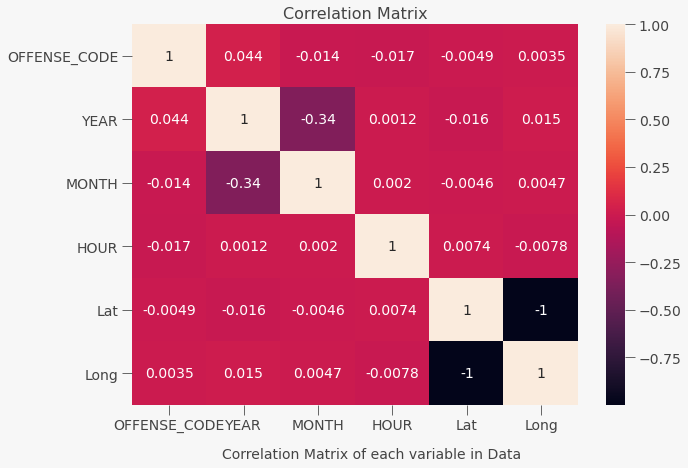

In [78]:
plt.figure(figsize=(10, 7))
BostonCorrMatrix = BostonCrimeDF.corr()
sns.heatmap(BostonCorrMatrix, annot=True)
plt.title('Correlation Matrix', fontsize=16);
figtext(.25, .02, "Correlation Matrix of each variable in Data")
plt.show()

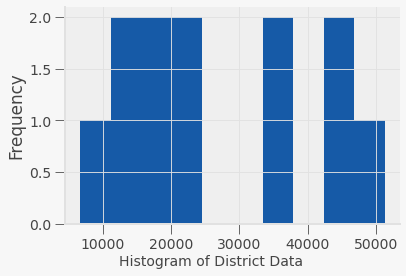

In [84]:
BostonCrimeDFCleaned["DISTRICT"].value_counts().plot.hist()
figtext(.25, -.02, "Histogram of District Data")

plt.show()

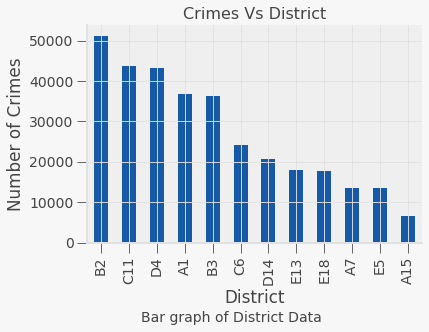

In [89]:
fig, gax = plt.subplots()

BostonCrimeDFCleaned["DISTRICT"].value_counts().plot.bar()

gax.set_xlabel('District')
gax.set_ylabel('Number of Crimes')
plt.title('Crimes Vs District', fontsize=16);
figtext(.25, -.15, "Bar graph of District Data")

plt.show()

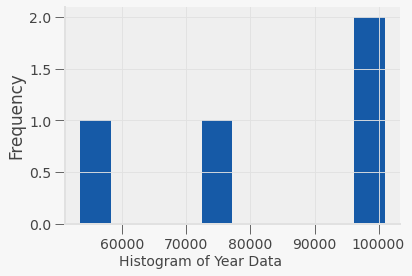

In [123]:
BostonCrimeDFCleaned["YEAR"].value_counts().plot.hist()
figtext(.25, -.02, "Histogram of Year Data")
plt.show()

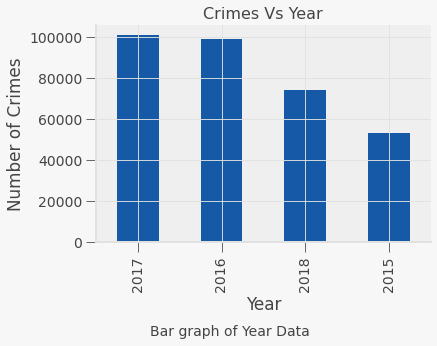

In [91]:
fig, gax = plt.subplots()

BostonCrimeDFCleaned["YEAR"].value_counts().plot.bar()

gax.set_xlabel('Year')
gax.set_ylabel('Number of Crimes')
plt.title('Crimes Vs Year', fontsize=16);
figtext(.25, -.2, "Bar graph of Year Data")

plt.show()

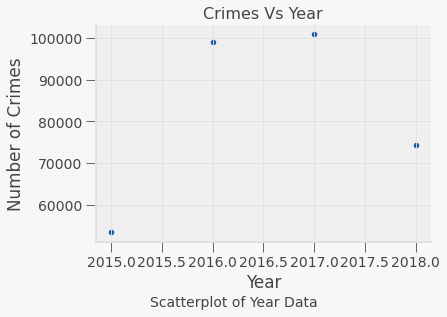

In [103]:
BostonCrimeYear = pd.DataFrame()

BostonCrimeYear = pd.DataFrame({'Year': BostonCrimeDF["YEAR"].unique()}).sort_values(by = 'Year').reset_index(drop=True)

BostonCrimeYear.index = BostonCrimeYear.index + 2015

BostonCrimeYear["Number of Crimes"] = pd.DataFrame(BostonCrimeDF["YEAR"].value_counts(sort = False))

BostonCrimeYear.plot.scatter(x="Year", y="Number of Crimes")
plt.title('Crimes Vs Year', fontsize=16);
figtext(.25, -.1, "Scatterplot of Year Data")

plt.show()

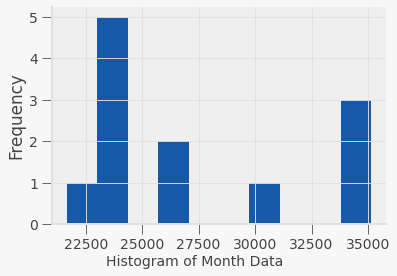

In [124]:
BostonCrimeDFCleaned["MONTH"].value_counts().plot.hist()
figtext(.25, -.02, "Histogram of Month Data")
plt.show()

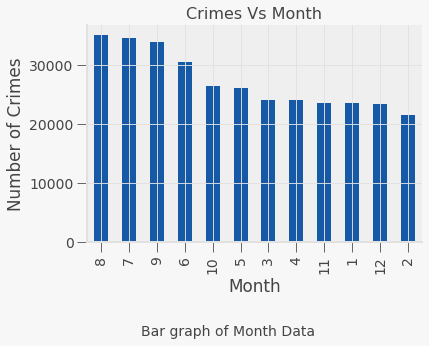

In [105]:
fig, gax = plt.subplots()

BostonCrimeDFCleaned["MONTH"].value_counts().plot.bar()

gax.set_xlabel('Month')
gax.set_ylabel('Number of Crimes')
plt.title('Crimes Vs Month', fontsize=16);
figtext(.25, -.2, "Bar graph of Month Data")

plt.show()

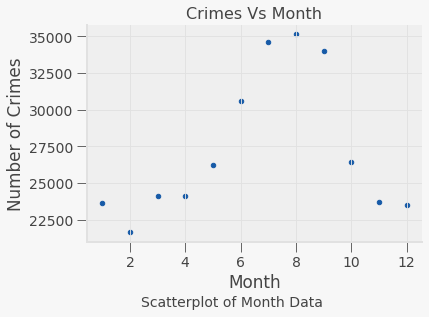

In [102]:
BostonCrimeMonth = pd.DataFrame()

BostonCrimeMonth = pd.DataFrame({'Month': BostonCrimeDF["MONTH"].unique()}).sort_values(by = 'Month').reset_index(drop=True)

BostonCrimeMonth.index = BostonCrimeMonth.index + 1

BostonCrimeMonth["Number of Crimes"] = pd.DataFrame(BostonCrimeDF["MONTH"].value_counts(sort = False))

BostonCrimeMonth.plot.scatter(x="Month", y="Number of Crimes")
plt.title('Crimes Vs Month', fontsize=16);
figtext(.25, -.1, "Scatterplot of Month Data")
plt.show()

Here we can see that there seems to be an uptick of crimes during the Summer months, with a significantly higher number of crimes occurring in July, June, August, and September, with crimes peaking in August.

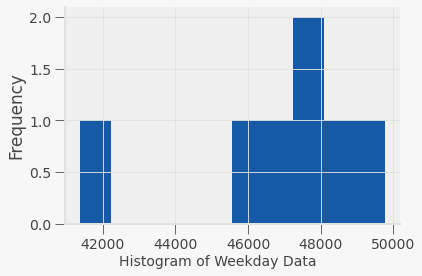

In [125]:
BostonCrimeDFCleaned["DAY_OF_WEEK"].value_counts().plot.hist()
figtext(.25, -.02, "Histogram of Weekday Data")
plt.show()

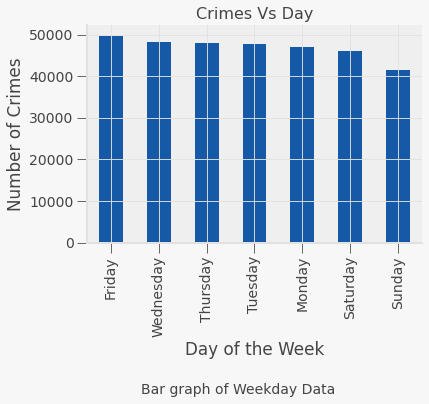

In [108]:
fig, gax = plt.subplots()

BostonCrimeDFCleaned["DAY_OF_WEEK"].value_counts().plot.bar()

gax.set_xlabel('Day of the Week')
gax.set_ylabel('Number of Crimes')
plt.title('Crimes Vs Day', fontsize=16);
figtext(.25, -.4, "Bar graph of Weekday Data")

plt.show()

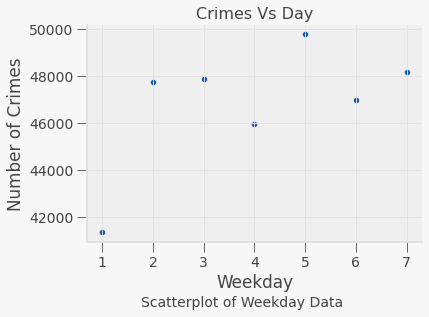

In [127]:
BostonCrimeWeek = pd.DataFrame()

BostonCrimeWeek = pd.DataFrame({'Weekday': [1, 2, 3, 4, 5, 6, 7], 'Number of Crimes' : BostonCrimeDF["DAY_OF_WEEK"].value_counts(sort = False)})

BostonCrimeWeek.plot.scatter(x="Weekday", y="Number of Crimes")
plt.title('Crimes Vs Day', fontsize=16);
figtext(.25, -.1, "Scatterplot of Weekday Data")

plt.show()

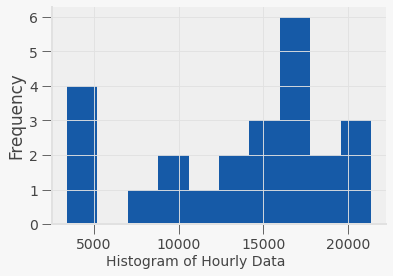

In [126]:
BostonCrimeDFCleaned["HOUR"].value_counts().plot.hist()
figtext(.25, -.02, "Histogram of Hourly Data")
plt.show()

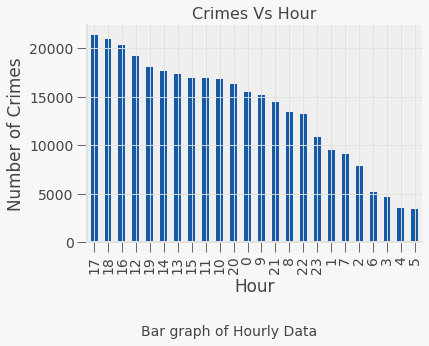

In [109]:
fig, gax = plt.subplots()

BostonCrimeDFCleaned["HOUR"].value_counts().plot.bar()

gax.set_xlabel('Hour')
gax.set_ylabel('Number of Crimes')
plt.title('Crimes Vs Hour', fontsize=16);
figtext(.25, -.2, "Bar graph of Hourly Data")

plt.show()

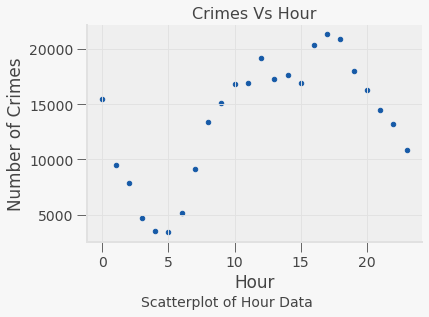

In [100]:
BostonCrimeHours = pd.DataFrame()

BostonCrimeHours = pd.DataFrame({'Hour': BostonCrimeDF["HOUR"].unique()}).sort_values(by = 'Hour').reset_index(drop=True)

BostonCrimeHours["Number of Crimes"] = pd.DataFrame(BostonCrimeDF["HOUR"].value_counts(sort = False))

BostonCrimeHours.plot.scatter(x="Hour", y="Number of Crimes")
plt.title('Crimes Vs Hour', fontsize=16);
figtext(.25, -.1, "Scatterplot of Hour Data")

plt.show()

# PROJECT TWO


## The Message

The question that I am looking to answer is whether there are any factors that may help predict crimes in Boston. The factors that will be examined are the hour of day, month and area of Boston. With these factors, I suspect we will be able to see when do crimes occur the most, both in terms of the specific time of day and the specific time of year, as well as which areas will there be more numbers of crimes.

For the first draft plot, we will be looking at the time of day, i.e. hour, that the crimes occur.

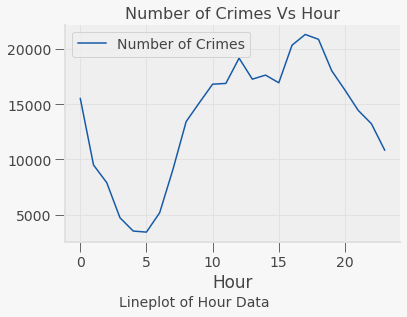

In [99]:
BostonCrimeHours = pd.DataFrame()

BostonCrimeHours = pd.DataFrame({'Hour': BostonCrimeDF["HOUR"].unique()}).sort_values(by = 'Hour').reset_index(drop=True)

BostonCrimeHours["Number of Crimes"] = pd.DataFrame(BostonCrimeDF["HOUR"].value_counts(sort = False))

BostonCrimeHours.plot(x="Hour", y="Number of Crimes")
plt.title('Number of Crimes Vs Hour', fontsize=16);
figtext(.25, -.1, "Lineplot of Hour Data")

plt.show()

As we can see that in general there seems to be certain times where crime is higher and when crime is lower. Most notably, we see the peak in crimes around 5 pm (Hour 17), while we see the lowest number of crimes around 5 am. This does make sense, as 5 am is when most people are sleeping and not active, so there would be significantly less crime. 

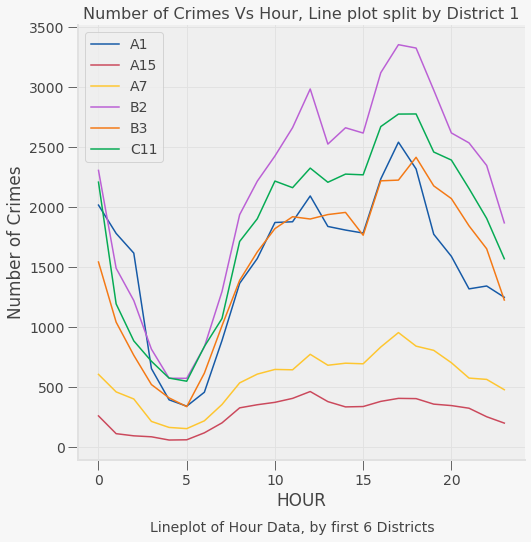

In [112]:
fig, gax = plt.subplots(figsize=(8,8))

GroupedData1 = BostonCrimeDF.groupby(["DISTRICT","HOUR"]).size().reset_index().groupby('HOUR').head(6)

GroupedData1.columns = ['DISTRICT', 'HOUR', 'COUNT']

sns.lineplot( x="HOUR", y="COUNT", data=GroupedData1, hue='DISTRICT', legend=False)
plt.title('Number of Crimes Vs Hour', fontsize=16);
gax.set_ylabel('Number of Crimes')  
figtext(.25, 0, "Lineplot of Hour Data, by first 6 Districts")


plt.legend(['A1', 'A15', 'A7', 'B2', 'B3', 'C11'])

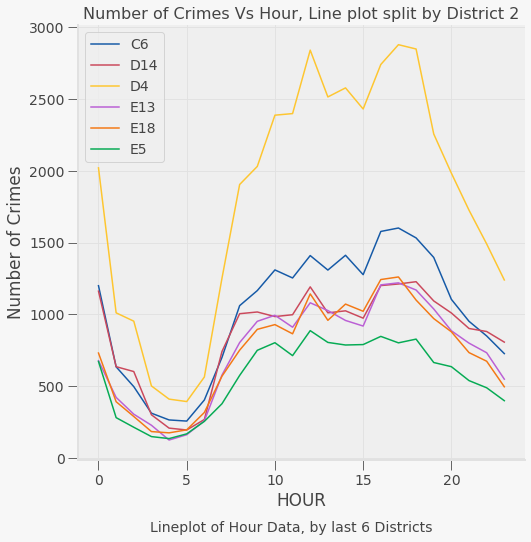

In [113]:
fig, gax = plt.subplots(figsize=(8,8))

GroupedData2 = BostonCrimeDF.groupby(["DISTRICT","HOUR"]).size().reset_index().groupby('HOUR').tail(6)

GroupedData2.columns = ['DISTRICT', 'HOUR', 'COUNT']

sns.lineplot( x="HOUR", y="COUNT", data=GroupedData2, hue='DISTRICT', legend=False)
plt.title('Number of Crimes Vs Hour, Line plot split by District 2', fontsize=16);
gax.set_ylabel('Number of Crimes')  
figtext(.25, 0, "Lineplot of Hour Data, by last 6 Districts")

plt.legend(['C6','D14', 'D4', 'E13', 'E18', 'E5'])

By grouping all the crime counts into each district, we can see that there are certain districts with higher numbers of crimes and certain ones with lower. More specifically, we can see that districts A1, B2, B3, C11 and D4 seem to have significantly higher rates of crime overall, as well this group seems to have a much wider range in the number of crimes, as their peaks are much higher than the other districts. In contrast, we see that the districts of A15, A7, C6, D14, E13, E18, and E5 seem to see lower peaks and overall lower levels of crime in general when comparing the the 5 high crime districts already mentioned. 

## The Effect of District on Crime

The following code and output is the Boston Police GIS data used in our analysis

In [37]:
PoliceDivisionData = gpd.read_file("https://opendata.arcgis.com/datasets/9a3a8c427add450eaf45a470245680fc_5.zip")

PoliceDivisionData.head(12)

,OBJECTID,DISTRICT,ID,BPDGIS_GIS,DISTRICT_,DISTRICT__,ShapeSTAre,ShapeSTLen,geometry
0,1,A15,A15,A,15,15,3.798392e+07,57616.007190,"MULTIPOLYGON (((-71.07416 42.39051, -71.07415 ..."
1,2,A7,A7,A,7,07,1.401151e+08,138468.216080,"MULTIPOLYGON (((-70.99644 42.39557, -70.99644 ..."
2,3,A1,A1,A,1,01,4.448484e+07,48957.671219,"POLYGON ((-71.05200 42.36884, -71.05169 42.368..."
3,4,C6,C6,C,6,06,1.236919e+08,93389.518748,"POLYGON ((-71.04406 42.35403, -71.04412 42.353..."
4,5,D4,D4,D,4,04,6.999546e+07,41016.808977,"POLYGON ((-71.07416 42.35724, -71.07359 42.357..."
5,6,D14,D14,D,14,14,1.236253e+08,58025.031627,"POLYGON ((-71.12573 42.36998, -71.12570 42.369..."
6,7,E13,E13,E,13,13,1.119017e+08,66958.441783,"POLYGON ((-71.11275 42.33181, -71.11272 42.331..."
7,8,E5,E5,E,5,05,1.916214e+08,87797.653480,"POLYGON ((-71.14093 42.27488, -71.14092 42.274..."
8,9,B3,B3,B,3,03,9.315897e+07,60468.088955,"POLYGON ((-71.08022 42.30466, -71.08014 42.304..."
9,10,C11,C11,C,11,11,1.329185e+08,121141.759523,"MULTIPOLYGON (((-71.06491 42.31686, -71.06492 ..."


In [38]:
DistrictLabelDF = pd.DataFrame({
    'District' : BostonCrimeDF["DISTRICT"].unique(),
    'Latitude' : [42.26, 42.35, 42.318, 42.355, 42.375, 42.2875,0, 42.34, 42.3125, 42.28, 42.3375, 42.375, 42.284],
    'Longitude' : [-71.135, -71.15, -71.09, -71.07, -71.035, -71.07,0, -71.085, -71.12, -71.09, -71.05,-71.07, -71.16]
}).dropna()

DistrictLabelDF["Coordinates"] = list(zip(DistrictLabelDF.Longitude, DistrictLabelDF.Latitude))
DistrictLabelDF["Coordinates"] = DistrictLabelDF["Coordinates"].apply(Point)

geoDistrictLabelDF = gpd.GeoDataFrame(DistrictLabelDF, geometry="Coordinates")
geoDistrictLabelDF

,District,Latitude,Longitude,Coordinates
0,E18,42.2600,-71.135,POINT (-71.13500 42.26000)
1,D14,42.3500,-71.150,POINT (-71.15000 42.35000)
2,B2,42.3180,-71.090,POINT (-71.09000 42.31800)
3,A1,42.3550,-71.070,POINT (-71.07000 42.35500)
4,A7,42.3750,-71.035,POINT (-71.03500 42.37500)
5,C11,42.2875,-71.070,POINT (-71.07000 42.28750)
7,D4,42.3400,-71.085,POINT (-71.08500 42.34000)
8,E13,42.3125,-71.120,POINT (-71.12000 42.31250)
9,B3,42.2800,-71.090,POINT (-71.09000 42.28000)
10,C6,42.3375,-71.050,POINT (-71.05000 42.33750)


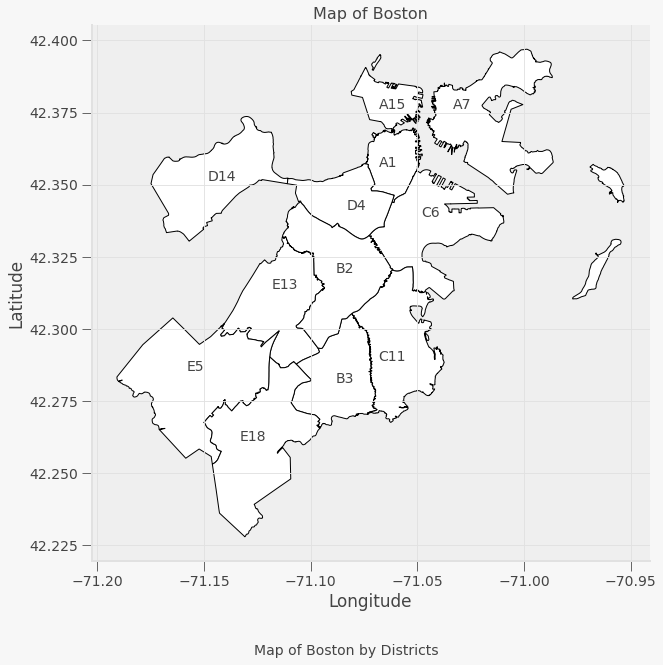

In [117]:
fig, gax = plt.subplots(figsize=(10, 10))

#CountyData.query("NAME == 'Boston'").plot(ax=gax, edgecolor="black", color="white")
PoliceDivisionData.plot(ax=gax, edgecolor="black", color="white")

gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude') 
plt.title('Map of Boston', fontsize=16);
figtext(.35, 0, "Map of Boston by Districts")

for x, y, label in zip(geoDistrictLabelDF['Coordinates'].x, geoDistrictLabelDF['Coordinates'].y, geoDistrictLabelDF['District']):
    gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')

plt.show()

We can see that Boston is seperated into 12 Police divisions, seen on the ploy above, and these will be the ones we will be looking at in our analysis

In [40]:
GroupedDataALL = pd.DataFrame(BostonCrimeDF["DISTRICT"].value_counts(sort = False)).reset_index()

GroupedDataALL.columns = ['DISTRICT', 'COUNT']

Below is the geometric data for the city of Boston, split into each district

In [41]:
PDCrimeGeoData = PoliceDivisionData.merge(GroupedDataALL,on="DISTRICT", how="inner")
                                          
PDCrimeGeoData              

,OBJECTID,DISTRICT,ID,BPDGIS_GIS,DISTRICT_,DISTRICT__,ShapeSTAre,ShapeSTLen,geometry,COUNT
0,1,A15,A15,A,15,15,3.798392e+07,57616.007190,"MULTIPOLYGON (((-71.07416 42.39051, -71.07415 ...",6663
1,2,A7,A7,A,7,07,1.401151e+08,138468.216080,"MULTIPOLYGON (((-70.99644 42.39557, -70.99644 ...",13634
2,3,A1,A1,A,1,01,4.448484e+07,48957.671219,"POLYGON ((-71.05200 42.36884, -71.05169 42.368...",36735
3,4,C6,C6,C,6,06,1.236919e+08,93389.518748,"POLYGON ((-71.04406 42.35403, -71.04412 42.353...",24190
4,5,D4,D4,D,4,04,6.999546e+07,41016.808977,"POLYGON ((-71.07416 42.35724, -71.07359 42.357...",43338
5,6,D14,D14,D,14,14,1.236253e+08,58025.031627,"POLYGON ((-71.12573 42.36998, -71.12570 42.369...",20632
6,7,E13,E13,E,13,13,1.119017e+08,66958.441783,"POLYGON ((-71.11275 42.33181, -71.11272 42.331...",17981
7,8,E5,E5,E,5,05,1.916214e+08,87797.653480,"POLYGON ((-71.14093 42.27488, -71.14092 42.274...",13543
8,9,B3,B3,B,3,03,9.315897e+07,60468.088955,"POLYGON ((-71.08022 42.30466, -71.08014 42.304...",36400
9,10,C11,C11,C,11,11,1.329185e+08,121141.759523,"MULTIPOLYGON (((-71.06491 42.31686, -71.06492 ...",43817


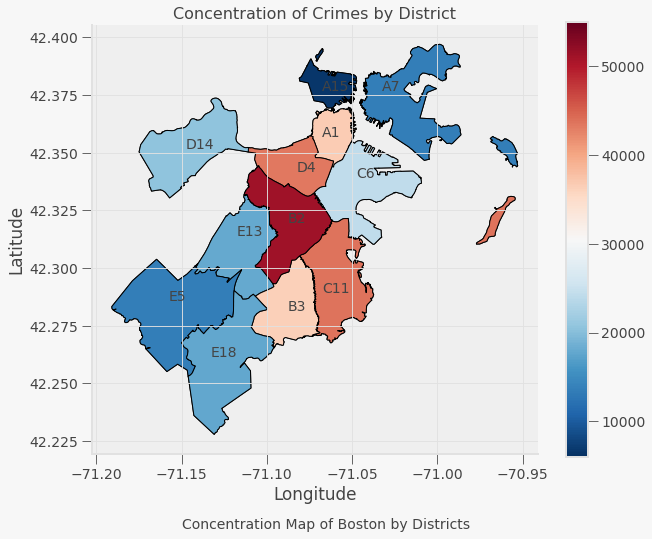

In [120]:
fig, gax = plt.subplots(figsize = (10,8))

PoliceDivisionData.plot(ax=gax, edgecolor="black", color="white")

gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude')  

PDCrimeGeoData.plot(
    ax=gax, edgecolor='black', column='COUNT', legend=True, cmap='RdBu_r',
    vmin=6000, vmax=55000 #range of your column value for the color legend
)

plt.title('Concentration of Crimes by District', fontsize=16);
figtext(.25, 0, "Concentration Map of Boston by Districts")


for x, y, label in zip(geoDistrictLabelDF['Coordinates'].x, geoDistrictLabelDF['Coordinates'].y, geoDistrictLabelDF['District']):
    gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')

  
    
plt.show()

We can see from the plot above that indeed there are certain areas that see a greater concentration of crimes, with B2 seeing the greatest number of crimes, and A15 seeing the least. Moreover, areas that are more red are areas with higher numbers of crime, and we can see that most of these areas are concentrated within the center of Boston, the inner city with higher densities of people, while areas that see less crime are more on the outskirts of Boston, or on isolated islands, which we would expect to find fewer people.

In [43]:
LatLongData = BostonCrimeDFCleaned[['Long','Lat']]

LatLongData = LatLongData.dropna()

LatLongData = LatLongData.loc[(LatLongData['Lat'] > 42) & (LatLongData['Long'] < -70)]  

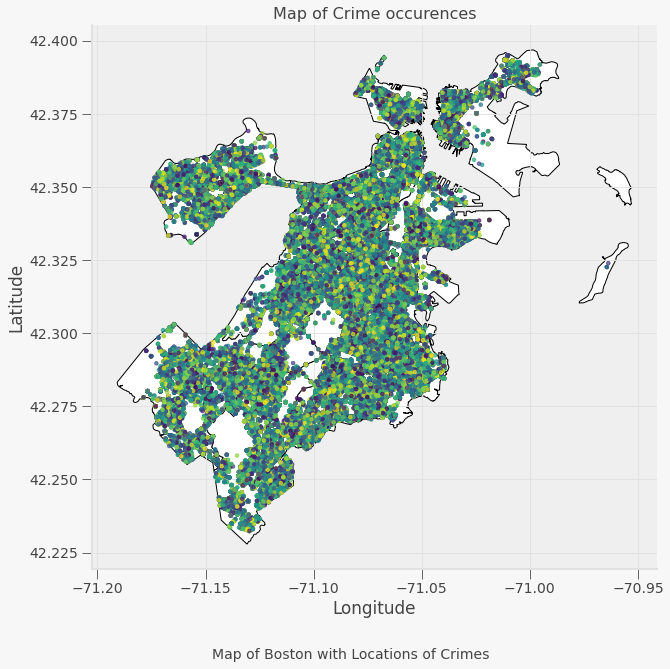

In [122]:
x = LatLongData['Long'].values
y = LatLongData['Lat'].values

colors = np.random.rand(len(x))

ax = PDCrimeGeoData.plot(edgecolor="black", color="white",figsize=(20,10))

ax.scatter(x, y, marker=".", c=colors, alpha=0.7, zorder=5, s=50)
figtext(.4, 0, "Map of Boston with Locations of Crimes")

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Map of Crime occurences', fontsize=16);
    
plt.show()

Creating a point map for individual crimes, we can find that there are certain areas where there are little to no crimes, most of which are part of blue areas in our previous concentration mapping. Furthermore, we can see that certain areas have high densely packed number of crimes, which may help provide us with information on where most crimes may occur in any given district, while other areas are less packed or see very little crime.

# PROJECT THREE
## The Effect of Weather on Crime

In this section of the analysis, we will be looking to use web-scraping to incorporate monthly weather data into our analysis.  Said data will be drawn from the US climate data site (https://www.usclimatedata.com/climate/boston/massachusetts/united-states/usma0601) which collects weather data from sources like the National Climatic Data Center. With this data we hope to use it to determine if there are any other factors or reasons, aside from ones already discussed, such as weather patterns or temperatures, have had any effect on the crime rate in Boston. 

By using this data we hope to be able to determine what weather conditions may lead to increases or decreases in the number of crimes that occur during the month, and by doing this multiple times throughout the year, we can increase the statistical power of the analysis as we increase the sample size we draw from. This web scraped data will need to be run on a monthly basis so as to best see the effects on crime that the weather may have contributed to, and to best make use of the weather data from the site. Using this data also comes with some unique challenges, for one, since this data is monthly, we are not able to see breakdown at the smaller levels, such as by week, days, or hours. Thus, we may run into difficulties with conducting hour analysis on the smaller levels of times, due to the lack of data specific to those times. Thus, further analyses on the smaller intervals of time, like average precipitation on a specific date over the years, may be needed to better identify potential effects on specific days or hours.

The following code will be the web-scraping and set up of the objects from the web-scraping, from which we will be able to extract data from the tables for our use.

In [45]:
import requests
from bs4 import BeautifulSoup

Boston_weather_web_url = 'https://www.usclimatedata.com/climate/boston/massachusetts/united-states/usma0601'
Boston_weather_response = requests.get(Boston_weather_web_url)

Boston_weather_soup_object = BeautifulSoup(Boston_weather_response.content)

# We can uncomment the below line to look into the contents of our soup_object
#Boston_weather_soup_object

The code used above generates a soup object, which is what we use to store and organize the HTML/XML information from the website. With that soup object, we now need to find the specific data and table we want to use, this can be seen in the following code:

In [46]:
Boston_weather_data_table1 = Boston_weather_soup_object.find_all('table', 'table table-hover tablesaw tablesaw-mode-swipe monthly_table')[0]
Boston_weather_data_table2 = Boston_weather_soup_object.find_all('table', 'table table-hover tablesaw tablesaw-mode-swipe mb-4 monthly_table')[0]

Boston_weather_all_values1 = Boston_weather_data_table1.find_all('tr')

Boston_weather_all_values2 = Boston_weather_data_table2.find_all('tr')

Once we have created the soup objects and collected the website data we need to convert that into a usable and readable form. This is done with the following code:

In [47]:
Boston_weather_df1 = pd.DataFrame(columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']) # Create an empty dataframe
ix = 0 # Initialise index to zero

for row in Boston_weather_all_values1[1:]:
    values = row.find_all('td') # Extract all elements with tag <td>
    # Pick only the text part from the <td> tag
    Jan = values[0].text
    Feb = values[1].text
    Mar = values[2].text
    Apr = values[3].text
    May = values[4].text
    Jun = values[5].text
    
    Boston_weather_df1.loc[ix] = [Jan, Feb, Mar, Apr, May, Jun] # Store it in the dataframe as a row
    ix += 1
    
Boston_weather_df1['Measure'] = ['Average high in ºF','Average low in ºF', 'Days with precipitation','Hours of sunshine','Av. precipitation in inch']    
Boston_weather_df1 = Boston_weather_df1[['Measure', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']]

Boston_weather_df2 = pd.DataFrame(columns = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # Create an empty dataframe
ix = 0 # Initializes index to zero

for row in Boston_weather_all_values2[1:]:
    values = row.find_all('td') # Extracts all elements with tag <td>
    # Picks only the text part from the <td> tag   
    Jul = values[0].text
    Aug = values[1].text
    Sep = values[2].text
    Oct = values[3].text
    Nov = values[4].text
    Dec = values[5].text
    
    Boston_weather_df2.loc[ix] = [Jul, Aug, Sep, Oct, Nov, Dec] # Store it in the dataframe as a row
    ix += 1    

Boston_weather_df2['Measure'] = ['Average high in ºF','Average low in ºF', 'Days with precipitation','Hours of sunshine','Av. precipitation in inch']    
Boston_weather_df2 = Boston_weather_df2[['Measure', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]


Boston_weather_df = pd.merge(Boston_weather_df1,Boston_weather_df2, on='Measure')
Boston_weather_df


,Measure,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Average high in ºF,36,39,45,56,66,76,81,80,72,61,51,41
1,Average low in ºF,22,25,31,41,50,60,65,65,57,47,38,28
2,Days with precipitation,11,9,11,11,12,10,9,9,8,9,10,11
3,Hours of sunshine,164,169,213,228,266,288,300,275,237,207,144,142
4,Av. precipitation in inch,3.35,3.23,4.29,3.74,3.46,3.66,3.43,3.27,3.43,3.94,3.98,3.78


Now that we have extracted the table from the website, we need to manipulate the data to align with the format we have been using thus far in the analysis. Furthermore, we need to merge this with the corresponding monthly data, which we will use to continue with our analysis.

In [48]:
Inverted_Boston_weather_df = Boston_weather_df.transpose()
Inverted_Boston_weather_df = Inverted_Boston_weather_df.drop(['Measure'])
Inverted_Boston_weather_df.columns = ['Average high in ºF','Average low in ºF', 'Days with precipitation','Hours of sunshine','Av. precipitation in inch']
Inverted_Boston_weather_df = Inverted_Boston_weather_df.apply(pd.to_numeric)

BostonCrimeMonthWeather = pd.merge(BostonCrimeMonth['Number of Crimes'], Inverted_Boston_weather_df, on = Inverted_Boston_weather_df.index)
BostonCrimeMonthWeather.columns = ['Month', 'Number of Crimes', 'Average high in ºF','Average low in ºF', 'Days with precipitation','Hours of sunshine','Av. precipitation in inch']

BostonCrimeMonthWeather

,Month,Number of Crimes,Average high in ºF,Average low in ºF,Days with precipitation,Hours of sunshine,Av. precipitation in inch
0,Jan,23625,36,22,11,164,3.35
1,Feb,21661,39,25,9,169,3.23
2,Mar,24156,45,31,11,213,4.29
3,Apr,24108,56,41,11,228,3.74
4,May,26242,66,50,12,266,3.46
5,Jun,30622,76,60,10,288,3.66
6,Jul,34640,81,65,9,300,3.43
7,Aug,35137,80,65,9,275,3.27
8,Sep,34023,72,57,8,237,3.43
9,Oct,26437,61,47,9,207,3.94


With the new set of data that we have created, we can now plot the information and compare that to the monthly crime rate plot we created in Part One. The code to do so and output can be seen below:

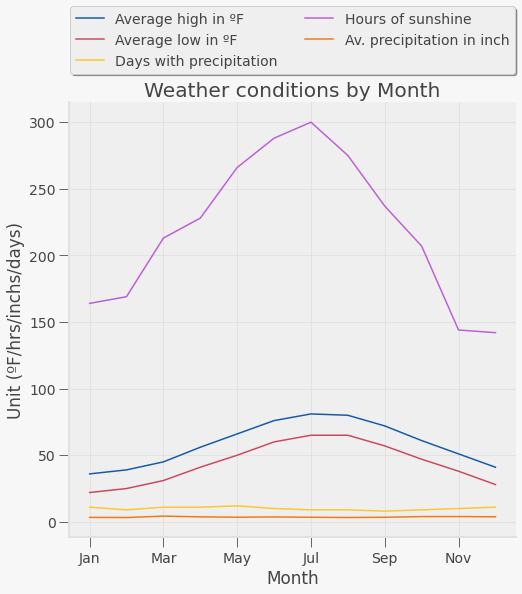

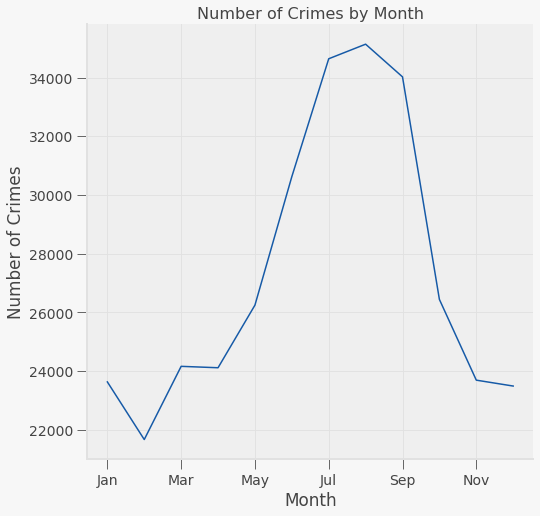

In [49]:
fig, gax = plt.subplots(figsize=(8,8))

Inverted_Boston_weather_df.plot.line(y="Average high in ºF", use_index = True, ax = gax)
Inverted_Boston_weather_df.plot.line(y="Average low in ºF", use_index = True, ax = gax)
Inverted_Boston_weather_df.plot.line(y="Days with precipitation", use_index = True, ax = gax)
Inverted_Boston_weather_df.plot.line(y="Hours of sunshine", use_index = True, ax = gax)
Inverted_Boston_weather_df.plot.line(y="Av. precipitation in inch", use_index = True, ax = gax, title='Weather conditions by Month')

BostonCrimeMonthWeather.plot.line(x="Month", y="Number of Crimes", figsize=(8,8), legend = False).set_ylabel('Number of Crimes')

gax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, shadow=True)

gax.set_xlabel('Month')
gax.set_ylabel('Unit (ºF/hrs/inchs/days)')

plt.title('Number of Crimes by Month', fontsize=16);

plt.show()

From the two plots we have created, we can see the number of crimes seem to be correlated with three out of five of our web scrapped categories, that being the total hours of sunshine in the month and the highest and lowest average temperature. We can see that the number of crimes seem to increase or decrease around the same time the general temperature and hours of sunshine increase or decrease. This seems to support our earlier hypothesis that crime numbers rise and fall during different times of year, and we now can see a few of the reason why this variation may happen. Based on our results so far, it seems reasonable to conclude that weather does affect the crime rate throughout the year, specifically during the warmer months crime increases, perhaps due to it being more comfortable, and thus more people will be out and about. With these warmer temperatures, more people will be outside of their homes, which can increase the potential number of crimes, as there are more potential victims and criminals outside. Additionally, the increases sunshine, which is also correlated with temperature, means people are going to be outside of their homes and other safer places for longer, which increases the window for any crimes to occur, as there are generally less people outside in darker hours. In contrast, during the winter time, we see a drop in the number of crimes, which also correlates with the categories we are looking at. This makes sense as during those months it will be colder outside, which deters people from leaving their homes and staying out too late, due to the temperature and the earlier sunsets during that period of the year. As a result, this drop in temperature and less amount of sunshine means that there will be less activity within Boston overall, as there are less potential victims or criminals outside of their homes. Thus, now that we have some potential reasons for why crimes would increase or decrease around specific times of the year.

On the other hand, it seems that the amount of percipitation likely has little to no effect on crime. Looking at the two catergories that characterize precipitation, 'Av. precipitation in inch' and 'Days with precipitation', we can see very little fluctuation from the tables and plot, so we can conclude that the amount of precipitation remain fairly constant throught the year. However, we can notice that while the precipitation remains unchanged, crime rates definitely varies throughout the year, this can possibly lead us to the conclusion that precipitation has little to no effect on crime. However, because there is so little variation with the precipitation, it is difficult to determine if there is any actual effect, as the effect could be crowded out by the temperature and sunshine variation. Thus, it seems that the analysis on precipitation seems inconclusive, and it is difficult to determine if there is any effect at all.

# Final Project

## Regression of the data

Now that we have provided some visual and supporting evidence about the question at hand, we need to conduct a formal Ordinary Least Square (OLS) regression analysis to truly see the exact effects of the discussed factors on the number of crimes in Boston. 

First we must start with importing all the required packages for this analysis

In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore')

Now as we recall from the work already done, the points of data in our analysis are non-linear, with most following a sinosoidal trend since we are dealing with recurring time data. Furthermore, from a visual inspection of the trends of the data, we can conclude that the data is non-linear since most of the data rises then falls, such as with the variables of hour, day, month and year, thus we must conduct a non-linear regression on our data. 

The variables we will be conducting a analysis on will be the variables for the hours, weekday, the average high & lows of temperatures in a month and the average number of hours of sunshine during the months. I suspect each of these will have some sort of effect as we suspect certain hours, and days will have some sort of effects on the number of crimes, and in the case of the weather conditions we suspect that the amount of time that day is bright has an effect on the number of crimes and the temperature outside would have an effect on the number of crimes. It should be noted that we have decided not to conduct a regression on sole the monthly number of crimes as we have scene in our weather analysis that the monthly effects are likely due to such weather variations, and as such we are regressing the weather conditions rather than the month variable. 

In [62]:
RegressionDFHour = BostonCrimeHours
RegressionDFHour['const'] = 1

HourRegression = sm.OLS(endog = RegressionDFHour['Number of Crimes'], exog = RegressionDFHour[['const','Hour']], \
                        missing = 'drop')
ResultsofHour = HourRegression.fit()
print(ResultsofHour.summary())

                            OLS Regression Results                            
Dep. Variable:       Number of Crimes   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     11.24
Date:                Fri, 18 Dec 2020   Prob (F-statistic):            0.00288
Time:                        13:22:46   Log-Likelihood:                -235.71
No. Observations:                  24   AIC:                             475.4
Df Residuals:                      22   BIC:                             477.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8365.3967   1842.789      4.540      0.0

In [63]:
RegressionDFWeek = BostonCrimeWeek
RegressionDFWeek['const'] = 1

WeekRegression = sm.OLS(endog = RegressionDFWeek['Number of Crimes'], exog = RegressionDFWeek[['const','Weekday']], \
                        missing = 'drop')
ResultsofWeek = WeekRegression.fit()
print(ResultsofWeek.summary())

                            OLS Regression Results                            
Dep. Variable:       Number of Crimes   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     2.488
Date:                Fri, 18 Dec 2020   Prob (F-statistic):              0.176
Time:                        13:22:47   Log-Likelihood:                -63.205
No. Observations:                   7   AIC:                             130.4
Df Residuals:                       5   BIC:                             130.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.398e+04   2019.035     21.784      0.0

In [65]:
RegressionDFSunshine = BostonCrimeMonthWeather
RegressionDFSunshine['const'] = 1

SunshineRegression = sm.OLS(endog = RegressionDFSunshine['Number of Crimes'], exog = RegressionDFSunshine[['const','Hours of sunshine']], \
                        missing = 'drop')
ResultsofSunshine = SunshineRegression.fit()
print(ResultsofSunshine.summary())

                            OLS Regression Results                            
Dep. Variable:       Number of Crimes   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     16.39
Date:                Fri, 18 Dec 2020   Prob (F-statistic):            0.00233
Time:                        13:22:48   Log-Likelihood:                -112.70
No. Observations:                  12   AIC:                             229.4
Df Residuals:                      10   BIC:                             230.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.208e+04   3872.38

In [66]:
RegressionDFWeather = BostonCrimeMonthWeather
RegressionDFWeather['const'] = 1

HighTempRegression = sm.OLS(endog = RegressionDFWeather['Number of Crimes'], exog = RegressionDFWeather[['const','Average high in ºF']], \
                        missing = 'drop')
ResultsofHighTemp = HighTempRegression.fit()
print(ResultsofHighTemp.summary())

LowTempRegression = sm.OLS(endog = RegressionDFWeather['Number of Crimes'], exog = RegressionDFWeather[['const','Average low in ºF']], \
                        missing = 'drop')
ResultsofLowTemp = LowTempRegression.fit()
print(ResultsofLowTemp.summary())


                            OLS Regression Results                            
Dep. Variable:       Number of Crimes   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     49.42
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           3.58e-05
Time:                        13:22:48   Log-Likelihood:                -107.83
No. Observations:                  12   AIC:                             219.7
Df Residuals:                      10   BIC:                             220.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.126e+04   2364

For our analysis, we have conducted 5 individual regressions for our 4 variables of interest, more specifically, we have conducted a OLS regression on the hour of the day, the day of the week, the hours of sunshine received by month and the temperatures by month, with two regressions being done for the latter on the high and low of the temperatures. These regressions were done on these variables as we suspected that there may be some relationship with these 4 indepedent variables on the number of crimes that occur in Boston, as we saw in previous projects that the number of crimes that have occurred do seem to change in accordance with these variables. In the previous sections, we saw that the time of day does seem to have an effect on the number of crimes as people committed less crimes as in the middle of the night and more crimes were observed in the day/evenings. Moreover, we also saw that crime numbers also seemed to change based on the day of the week which is also one of the regressions we conducted. Finally we saw in the most recent project, that certain weather conditions throughout the year seem to correllate with the number of crimes occuring, which is why we conducted regressions on the sunshine and temperatures.

From these regressions, we can see that for the most part, 4 out of 5 of our regressions find statistically significant changes and coefficient of estimates for each of our variables. The specific variables that were found to have statistical significance were the hours of the day, the amount of sunshine, and the two temperature regressions conducted. In the case of the hour regression, we found that the coefficient estiamte was 460.3278, thus this means that for every additional hour after midnight, there was an increase of 460 crimes over the course of the 4 years we examined, thus on any given day, every hour that passes after midnight would see a very small increase in the number of crimes by 0.31 (460 over the 4 years). Thus, we would expect that for any given day we see a crime roughly 3 hours after midnight, with more occurring as time goes on. Additionally, we can see that this coefficient is statistically significant because we can see that the t-value, 3.353, of the coefficient is greater than the t-critical level, 1.96, for 95% significance, we can also see a very small p-value, 0.003, and a 95% confidence interval that does not contain zero. Thus, by these facts we can conclude that the hour does indeed have a statistically significant effect on crime, with more crimes occuring as night turns to day, which makes sense. 

Now, looking at the sunshine regression, we can see that there is a coefficient of 69.4269, which means that the number of crimes increases by 69.4269 every month, as the hours of sunshine increases. This coefficient is also statistically significant as we can see a t-value of 4.049, p value of 0.002 and 95% confidence interval excluding 0. Thus, this suggests that the number of crimes do in fact increase as the enter months with more hours of sunshine, which would align with our initial hypothesis proposed in project 3. This is also the case with our temperature regressions, for the high temperature regression, we see a coefficient of 273.7462, which means that we do see crime increase as the months get warmer in Boston. Once again we can refer to the t-value, p-value and 95% confidence interval to confirm that this coefficient is statistically significant, with the t and p values being 7.030 and 0.000 respectively, both indicating significance. Moreover, our low temperature regression had a coefficient of 289.2845, which is also statistically significant, looking at the t value, 7.187, p-value, 0.000, and 95% confidence interval. Thus, this fact combined with the high temperature regression indicates that as average temperatures increase over the course of the year, the number of crimes that occur increase as well, which again aligns with our initial conclusion in project three. Finally, looking at the regression that didn't seem to be statistically significant, the regression on week day, we can conclude that perhaps on any given day of the week, the number of crimes that occur during that day did not change significantly over the course of the 4 years in the data we used. Thus, our results indicate that there is likely no effect that the day of the week has on the number of crimes that occur. 

Additionally if we look at all of the R squared values for each of our coefficients, we can see that weather conditions had relatively high values, with the temperature regressions seeing the greatest values, with those having values around roughly 90%. Thus, this suggests that the regressions we conducted do fit the data pretty well, especially for the temperature data we had. On the other hand, we saw very small values for the week regression, and relatively small values for the hour regression. Thus this indicates that the regression we conducted on either may not have been the best for each set of data, as the data did not fit too well with the regressions we conducted. As a result, other types of regressions may yield better results or more conclusive conclusions. 

From our regression analysis, we find that there are certain numerical variables that can potentially contribute to the number of crimes that have occurred in Boston, with those variables being the hour of day it is, the amount of sunshine the city recieves in any given month and the temperatures the city sees in any given months. 

# Conclusion

Crime in Boston, or any city for a matter of fact, is going to persist, however, the number of crimes can be heavily influenced by many factors. In our analysis we hoped to determine whether temporal factors such as time of year, the day of the week or the hour of day had any effect on the number of crimes in Boston. Along with these temporal factors we also examined the effect that certain areas or weather conditions had on the number of crimes that occurred. After doing so we found that many of our hypothesized factors may have influence on the number of crimes seen in Boston throughout 2015-2018. From the graphical analysis we have done, we can see that there are certainly many factors that contribute to the numbers of crimes that occur within Boston, such as the time of day it is, what time of year it is or the area of Boston we are looking at. Additionally, we have proposed possible reasons for such increases, with one of the primary factors being overall weather conditions at the time, with the temperatures and overall sunshine in a day being correlated on the number of crimes in a given timespan.  Additionally, an ordinary least squares regression analysis was conducted on the time of day, the day of the week, the amount of sunshine Boston recieves in any given month and the average temperature that Boston experiences in each month. This analysis found positive relationships with the number of crimes and the hour of day, amount of sunshine and average temperature experienced in Boston at different times, finding statistical significance in each of the OLS regressions for these variables. From this analysis, we also found that there may not be too much effect from the day of the week on the number of crimes that occur in Boston, as we found no staistically significant effect. Therefore, we have provided further evidence in support that certain variables such as the hour of day and specific weather conditions like amount of sunshine and temperature, do indeed have some effect on the number of crimes in Boston. As a result of our graphical and regression analysis, we can recommend that we would likely want to concentrate and allocate policing efforts based on when it is or what area it is, with more effort put towards areas like B2, during the afternoon/evening hours around 5 pm, during the summer months, or warmer and brighter times of the year. On the other hand, we may not need to have as much policing in areas with lower numbers of crimes, like A15, during the early morning hours, around 5 am, during the winter months, or during colder and darker times of year.

# Future Work

Although we did find that there are certain relationships that can be established with the number of crimes and temporal or spatial variables, further work is likely necessary to find more solid conclusions on the variables that we may not have seen any or as strong pieces of evidence for. More specifically, more work is likely needed on the effect on crime rates from the year it is, as we cannot really determine specific causes for changes to the number of crimes in any given year, and the day of the week, as we did not find conclusive results from our regressional analysis. Furthermore, more or different analyses may be required for the hour of days effect on crime, as we found relatively small R squared values from our regression analysis, being 0.332, meaning that our regression does not fit the data too well, but we can graphically see there is likely a very large effect on crime numbers. Moreover, the work conducted in this analysis may be limited by the lack of data points, in some cases we only had 4 points of data like with the graphical analysis of year. As a result, we may be better able to support our findings and potentially find new findings given we had more points of data, which would overall increase the statistical power of our analysis. Though nevertheless, we are still able to make some conclusions about crime numbers given our limitations.